# Dynamic Linear Regression

Suppose we have a variable of interest $Y$, indexed in time, as well as time series of $m$ features, $x_t$.

We start by fitting a linear regression model, $Y_t = x'_t \beta + \epsilon_t$, with i.i.d. Normal error $\epsilon_t$. 

The model fit looks fair, but upon closer inspection of the residuals we notice that they have some temporal structure. Perhaps we are missing an important feature. However, in this notebook we explore another possibility: what if the regression coefficients $\beta$ actually change over time?

Under this hypothesis, we build the following Dynamic Linear Regression model:

$$Y_t = x'_t \mu_t + \epsilon_t, $$

$$\mu_t = \mu_{t-1} + \nu_t, $$

$$\epsilon_t \sim N[0, 1 / \sigma^2], $$

$$\nu_t \sim N[0, 1 / \tau^2 I], $$

$$\mu_0 \sim N[0, I], $$

$$\sigma^2 \sim G[a_0, b_0], $$

$$\tau^2 \sim G[g_0, h_0], $$

where
- we we place $m$, preferably standardized features in the $m\times 1$ vector $x_t$;
- the observation error $\epsilon_t$ is i.i.d. Normal (as before);
- the $m$ regression coefficients $\mu_t$ evolve as a random walk;
- the $m$ random walk shocks $\nu_t$ are i.i.d. Normal;
- before observing any data, we assume the regression coefficients are i.i.d. Normal with mean 0 and variance 1.

To fit this model, we are going to:
- simulate data where the regression coefficients follow a sinusoidal pattern;
- create two objects of classes DynamicRegression and DynamicRegressionPlotter, designed with TFP for this purpose;
- obtain Maximum A Posteriori estimates for parameters $\sigma^2$ and $\tau^2$;
- sample the latent state $\mu_t$ given the MAP estimates and compare model predictions to observations;
- obtain Variational Bayes approximate distributions for $\sigma^2$ and $\tau^2$;
- sample $\mu_t$ given the VB samples of $\sigma^2$ and $\tau^2$ and compare model predictions to observations;

## Set up

Loading libraries, initializing objects, and simulating data

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from dynamic_regression import DynamicRegression, DynamicRegressionPlotter

In [2]:
dr = DynamicRegression()
pl = DynamicRegressionPlotter(model=dr)

In [3]:
dr.methods()

['fit_map',
 'fit_vb',
 'get_diagnostics',
 'get_forecast_residuals',
 'get_mu_distribution',
 'get_one_step_forecast_moments',
 'get_posterior_predictive_distribution',
 'get_sample_from_prior',
 'get_simulated_data',
 'get_smoothed_mu_moments',
 'get_vb_parameter_sample',
 'set_metadata',
 'set_model',
 'set_options']

In [4]:
times = pd.date_range(start='1951-01', end='1979-12', freq='MS')
n = len(times)
np.random.seed(0)
df = pd.DataFrame({'time': times,
                   'pred0': np.random.standard_normal(size=n),
                   'pred1': np.random.standard_normal(size=n)})
df['response'] = (
    (1 + 0.5 * np.cos(np.arange(n) * np.pi / n)) * df['pred0'] +
    (-1 + 0.5 * np.sin(np.arange(n) * np.pi / n)) * df['pred1'] + 
    0.1 * np.random.standard_normal(size=n))
df

,time,pred0,pred1,response
0,1951-01-01,1.764052,0.578521,2.032932
1,1951-02-01,0.400157,0.349654,0.172688
2,1951-03-01,0.978738,-0.764144,2.245070
3,1951-04-01,2.240893,-1.437791,4.887447
4,1951-05-01,1.867558,1.364532,1.316334
...,...,...,...,...
343,1979-08-01,-1.214077,0.949246,-1.713076
344,1979-09-01,-0.440923,-1.502397,1.421597
345,1979-10-01,-0.280355,-1.777667,1.643568
346,1979-11-01,-0.364694,-0.532703,0.406333


In [5]:
dr.set_options({"sigma2_concentration": 0.1,
                "sigma2_rate": 0.1,
                "tau2_concentration": 1, 
                "tau2_rate": 1,
                "latent_process_initial_scale": 1,
                "object_seed": 1})
dr.set_model(df=df,
             response_name='response',
             time_name='time',
             features_names=['pred0', 'pred1'])

Let's plot the data (black dots) together with samples from the DLR model, based on a vague guess for $\sigma^2$ and a high value for $\tau^2$, to approximate the model with time-invariant regression coefficients.

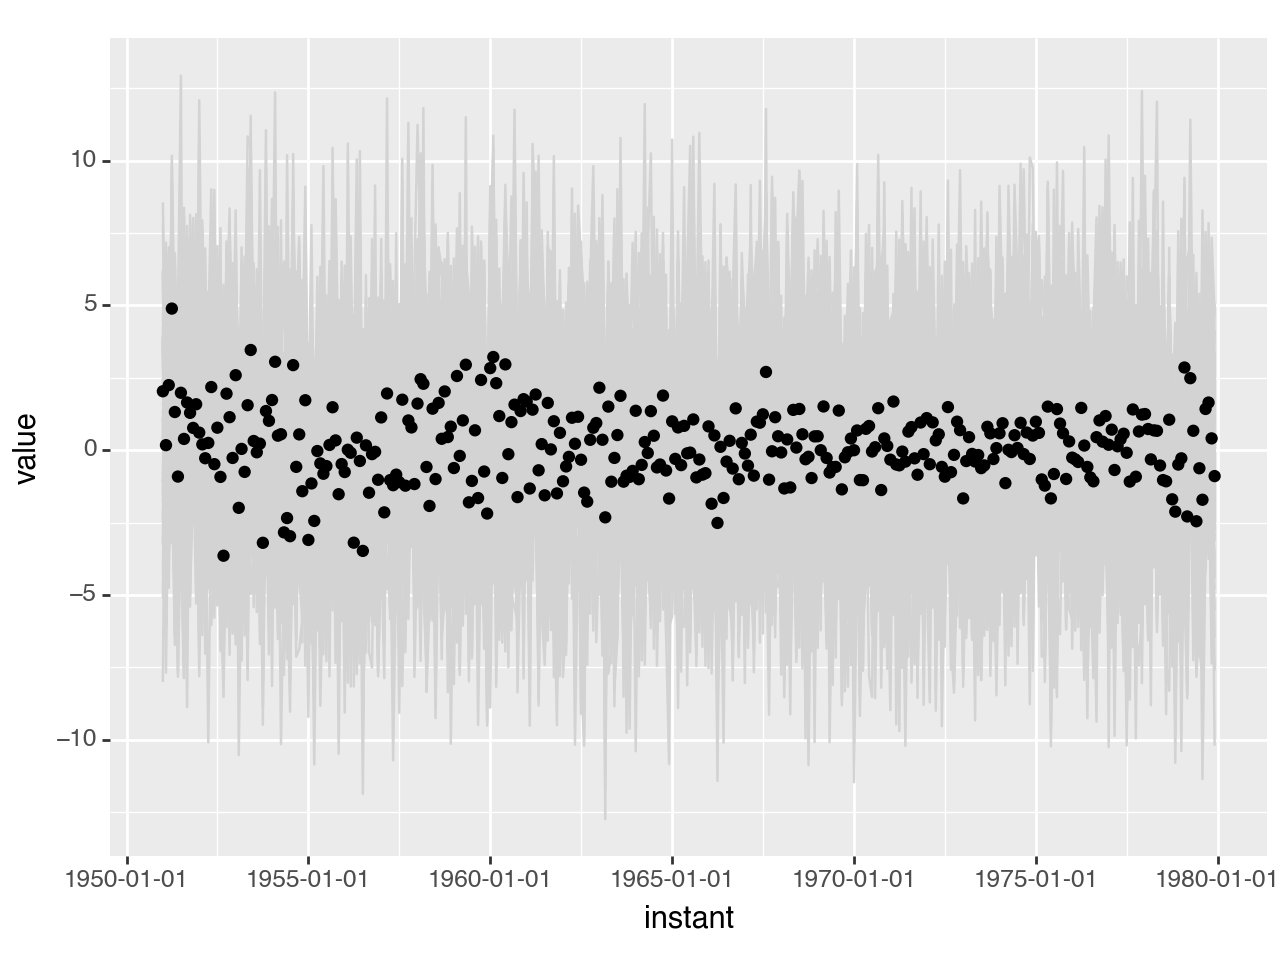

<Figure Size: (640 x 480)>

In [6]:
sigma2 = tf.cast(tf.constant(0.1), dtype=tf.float32)
tau2 = tf.cast(tf.constant(1e12), dtype=tf.float32)
params = {'sigma2': sigma2, 'tau2': tau2}

pl.timeseries_obs_vs_fit(lines=False, points=True, params=params, num_model_samples=60)

Next we plot the estimated means +/- 2 sds for the regression coefficients. Given the high value of $\tau^2$, the coefficients appear time-invariant.

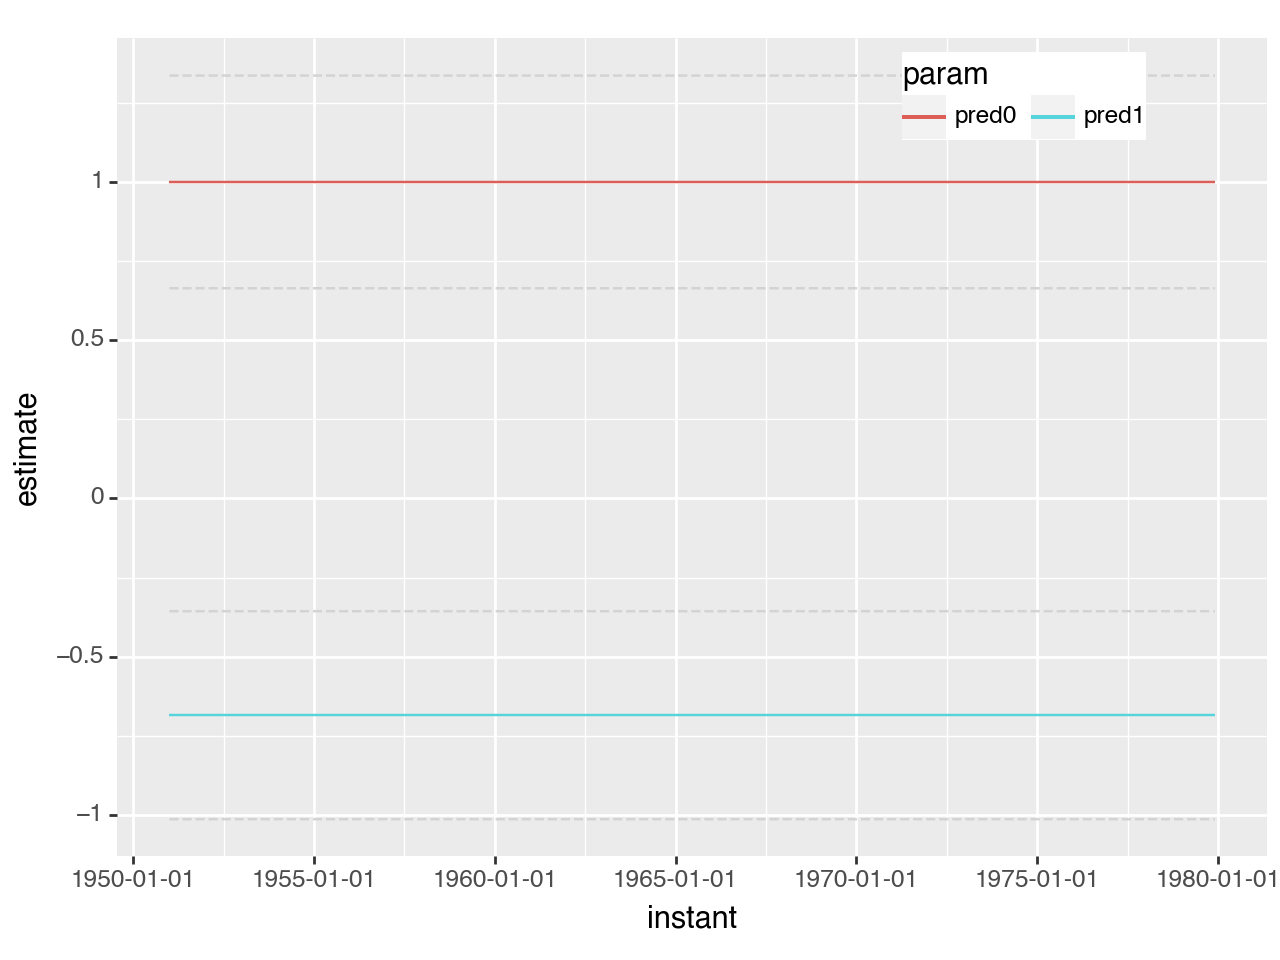

<Figure Size: (640 x 480)>

In [7]:
pl.timeseries_regression_coeffs(params=params)

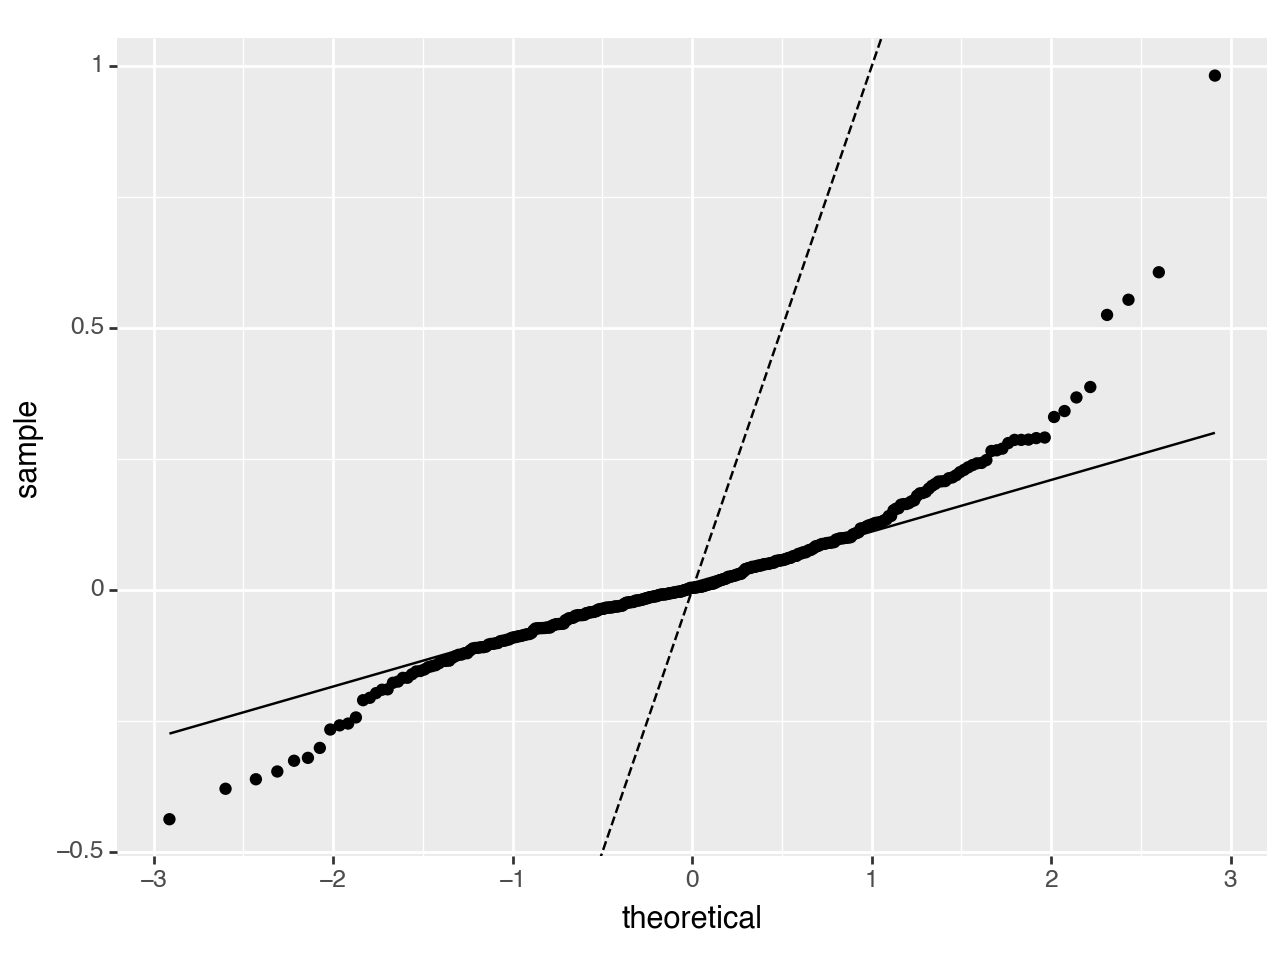

<Figure Size: (640 x 480)>

In [8]:
pl.forecast_residuals_qqplot(params=params)

## Maximum A Posterior estimation

Let us now get MAP estimates.

In [9]:
map_params, map_losses = dr.fit_map(
    learning_rate=0.5,
    num_steps=4000,
    jit_compile=False)
map_params

{'sigma2': <TransformedVariable: name=map_sigma2, dtype=float32, shape=[], fn="softplus", numpy=99.59477>,
 'tau2': <TransformedVariable: name=map_tau2, dtype=float32, shape=[], fn="softplus", numpy=80.45848>}

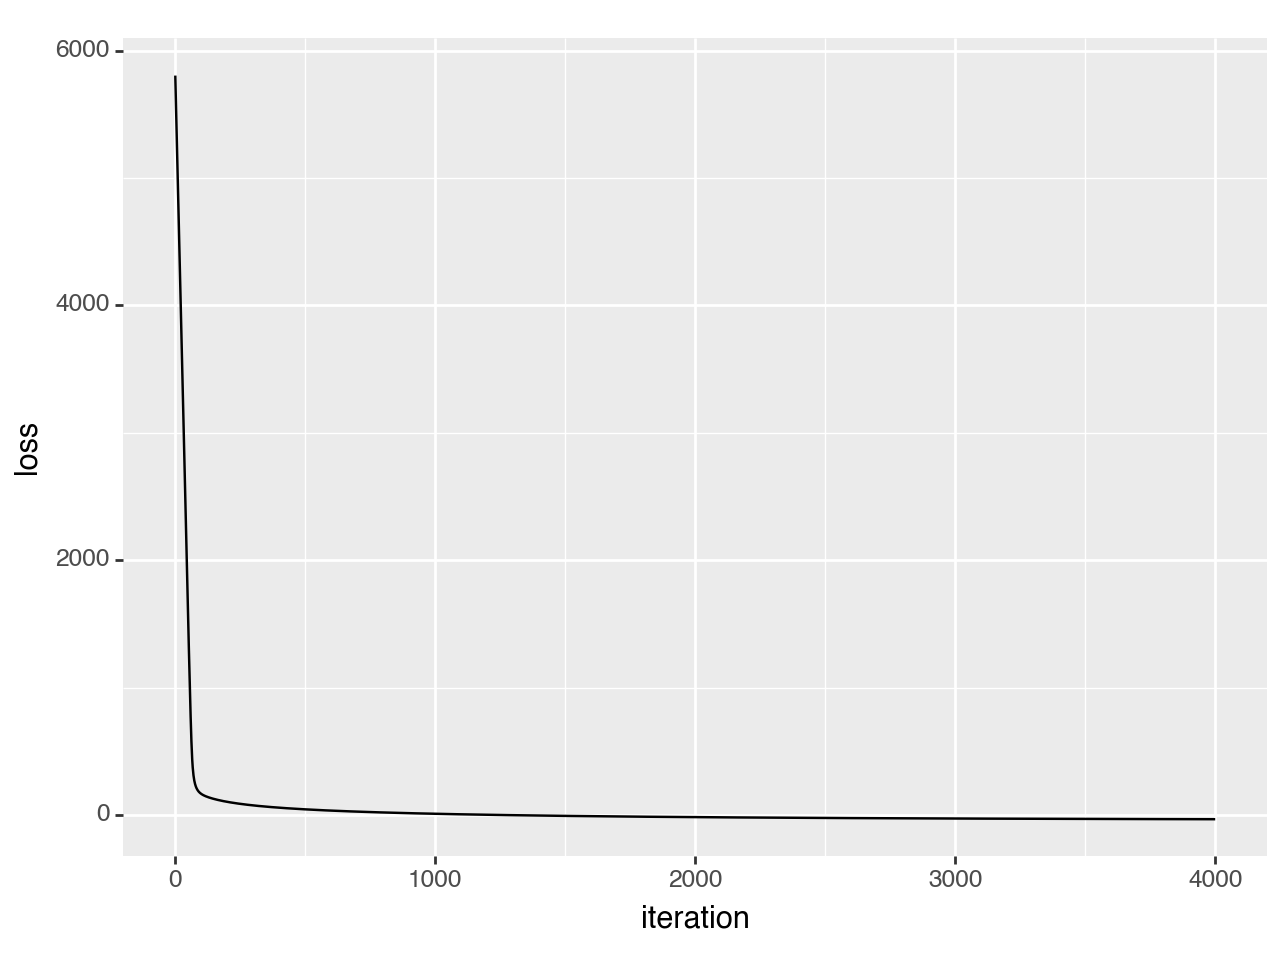

<Figure Size: (640 x 480)>

In [10]:
# plot the loss of this model fit, to assess convergence
pl.losses(map_losses)

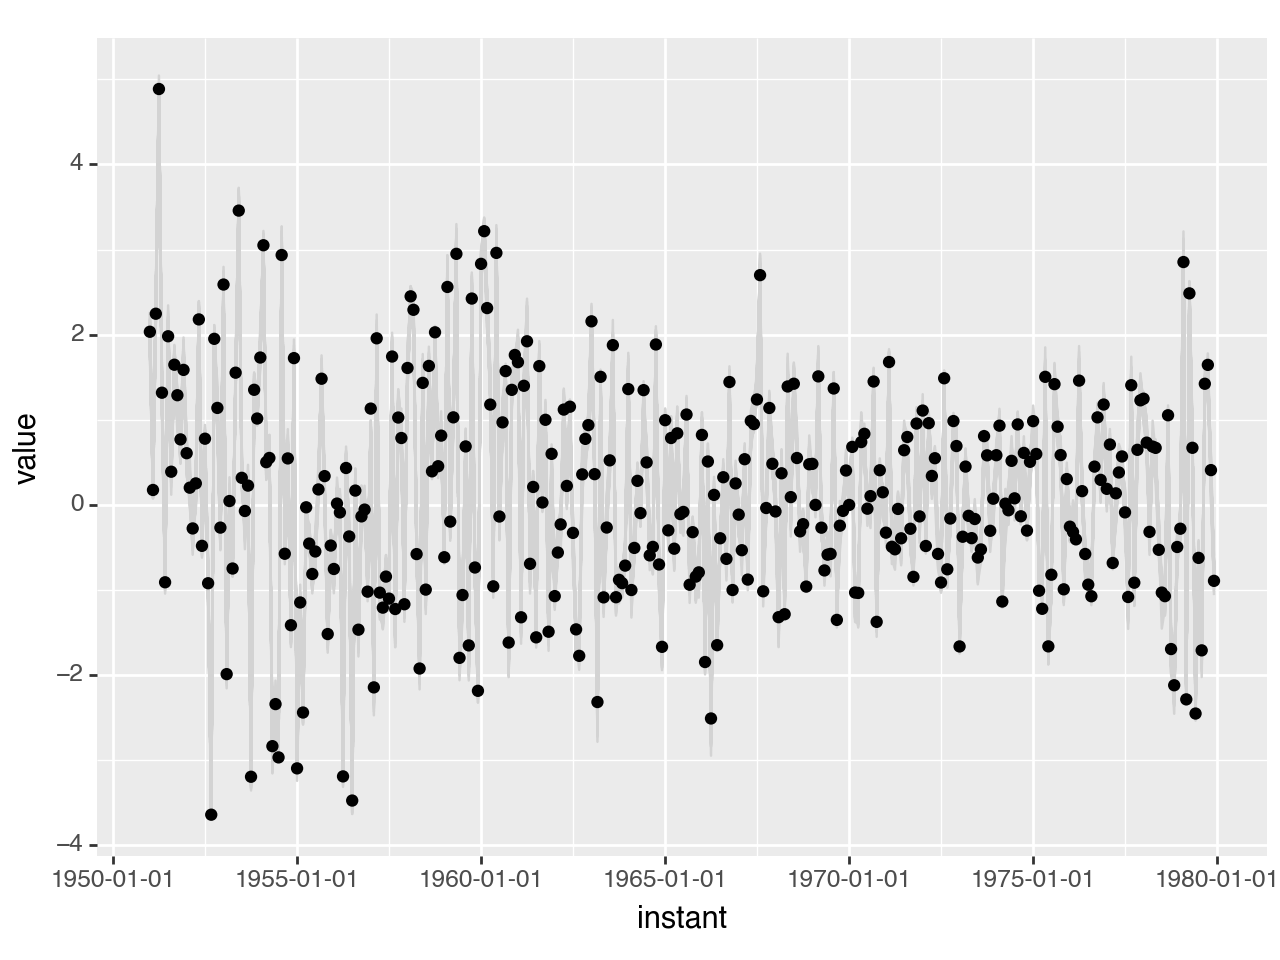

<Figure Size: (640 x 480)>

In [11]:
# plot the new time series of fitted values vs obs
pl.timeseries_obs_vs_fit(lines=False, points=True, params=map_params, num_model_samples=60)

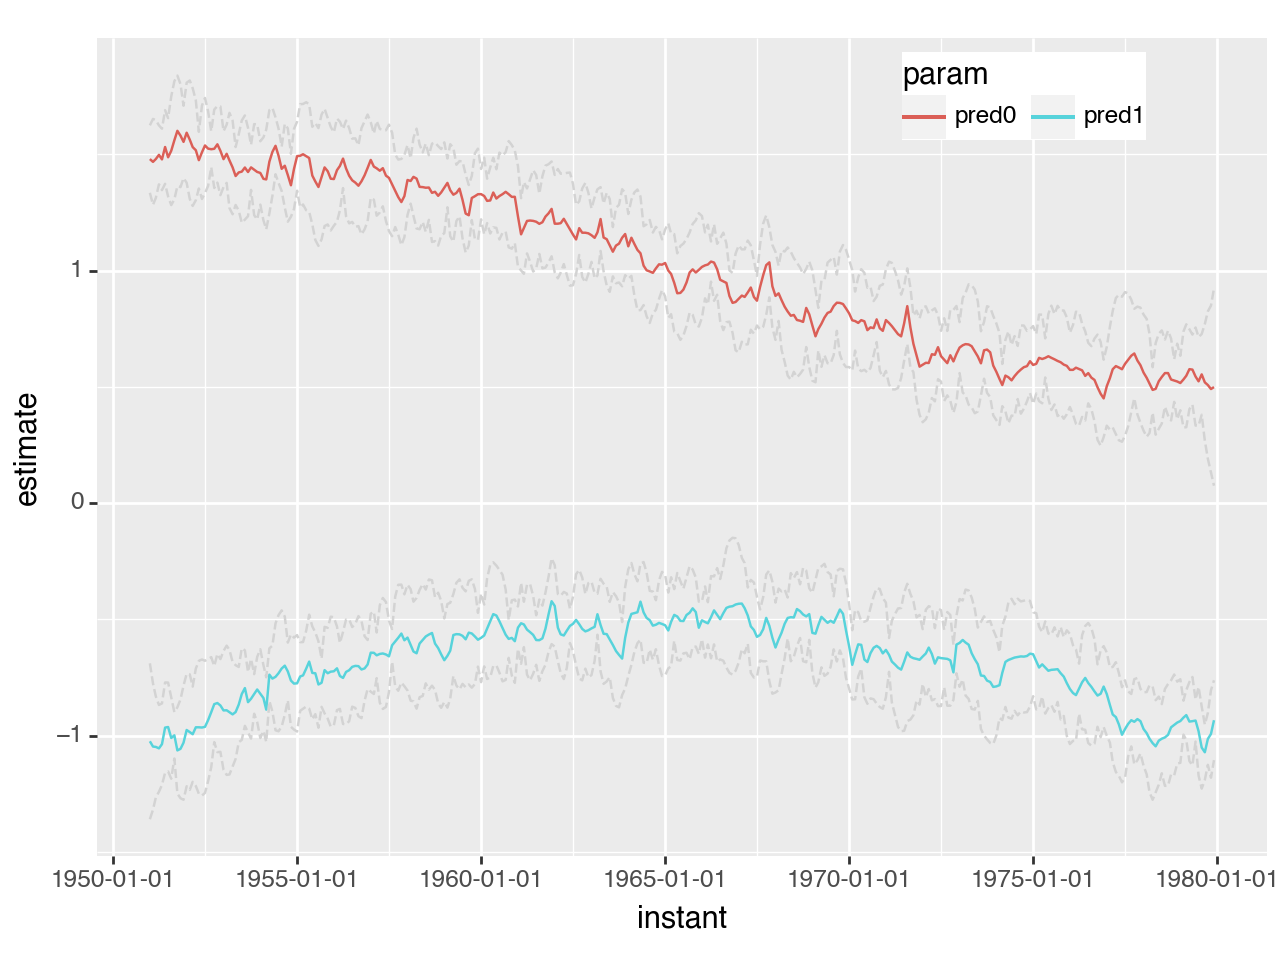

<Figure Size: (640 x 480)>

In [12]:
# plot the estimated means +/- 2 sds for the regression coefficients
pl.timeseries_regression_coeffs(params=map_params)

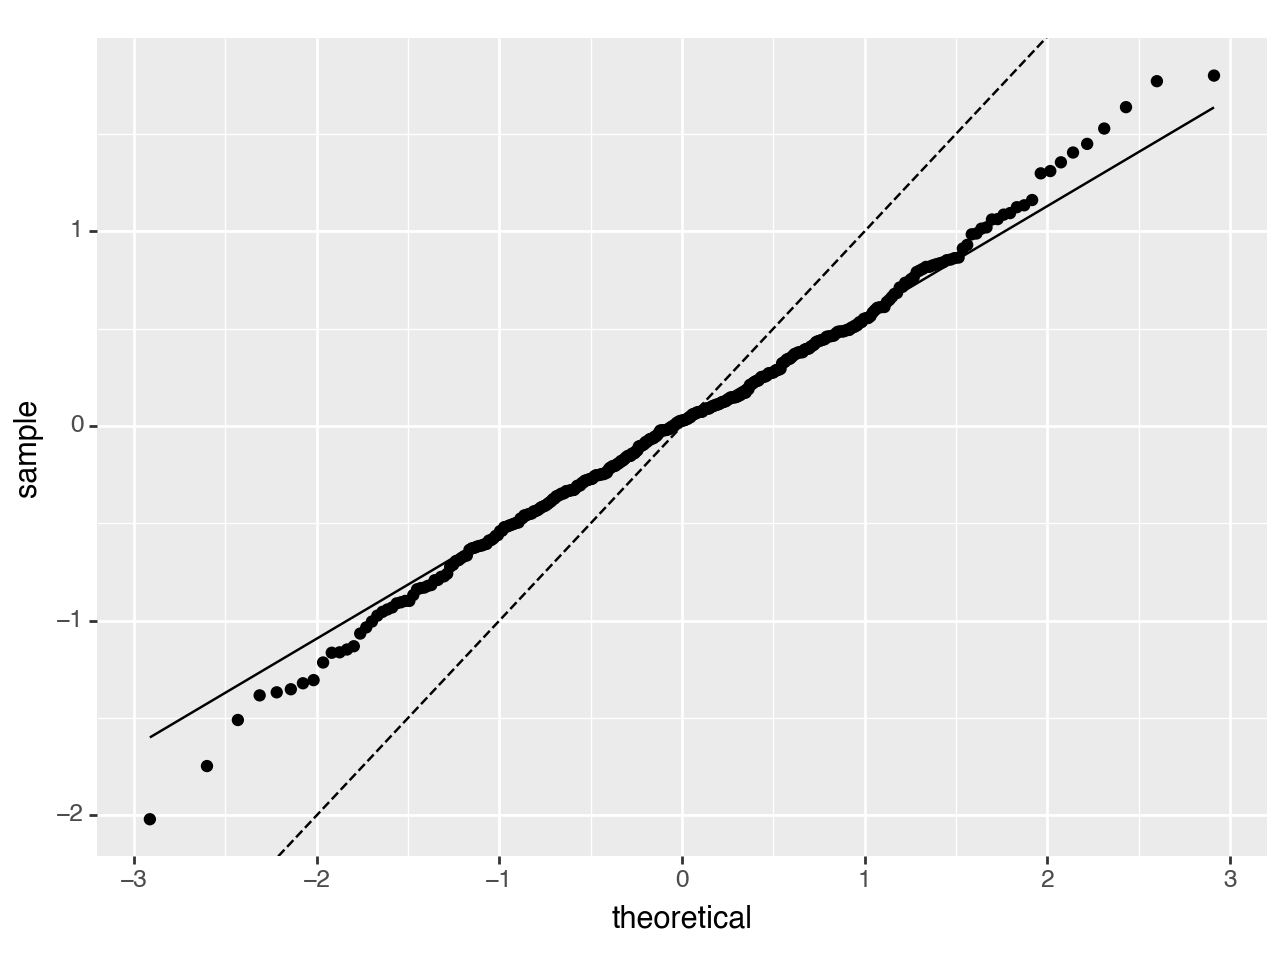

<Figure Size: (640 x 480)>

In [13]:
pl.forecast_residuals_qqplot(params=map_params)

## Variational Bayes estimation

Finally, we attempt to estimate approximate posterior distributions using Variational Bayes methods.

In [20]:
vb_param_q, vb_losses = dr.fit_vb(learning_rate=0.5,
                                  num_steps=1000)

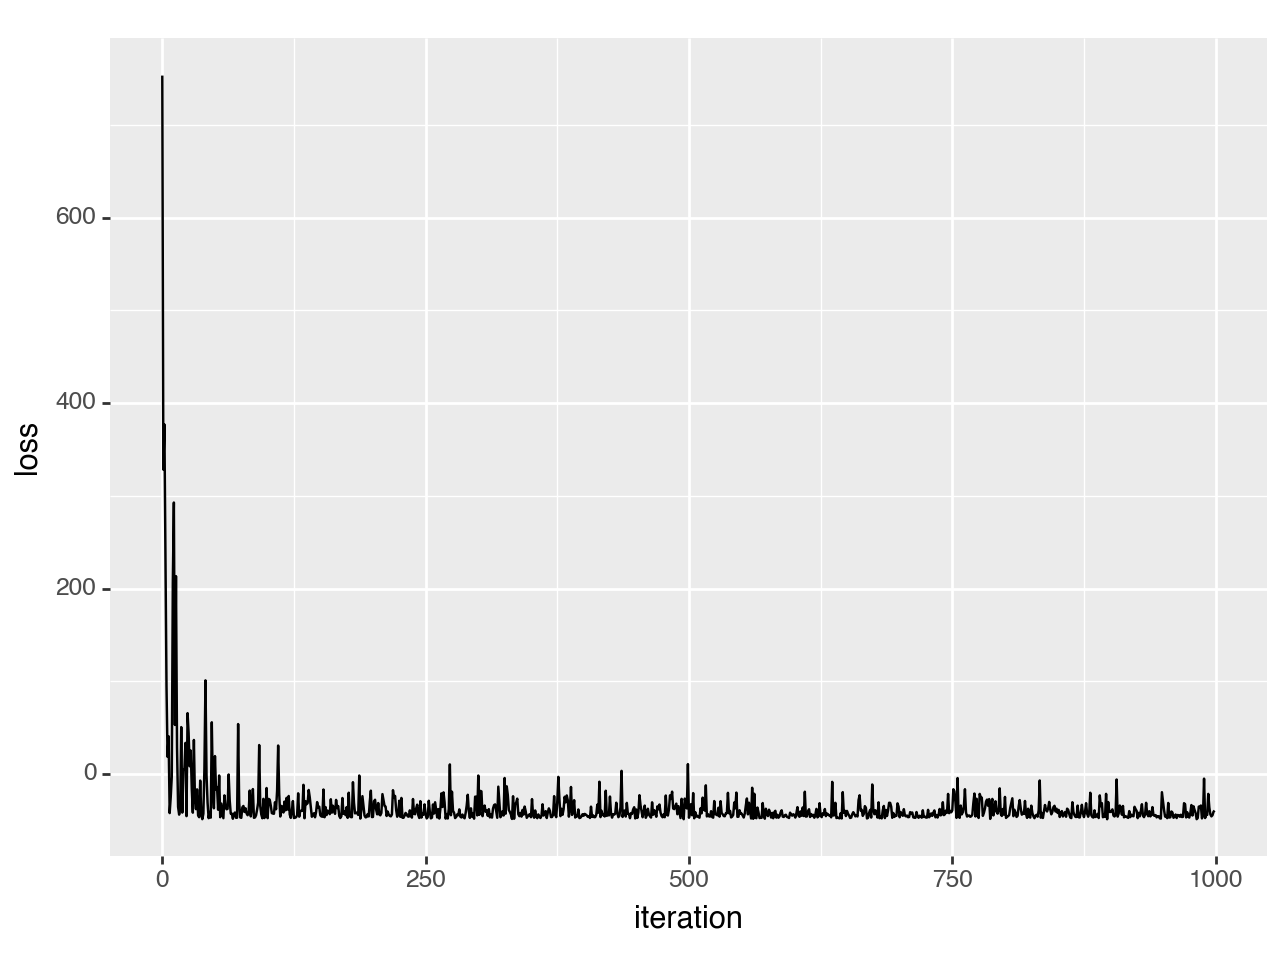

<Figure Size: (640 x 480)>

In [21]:
pl.losses(vb_losses)

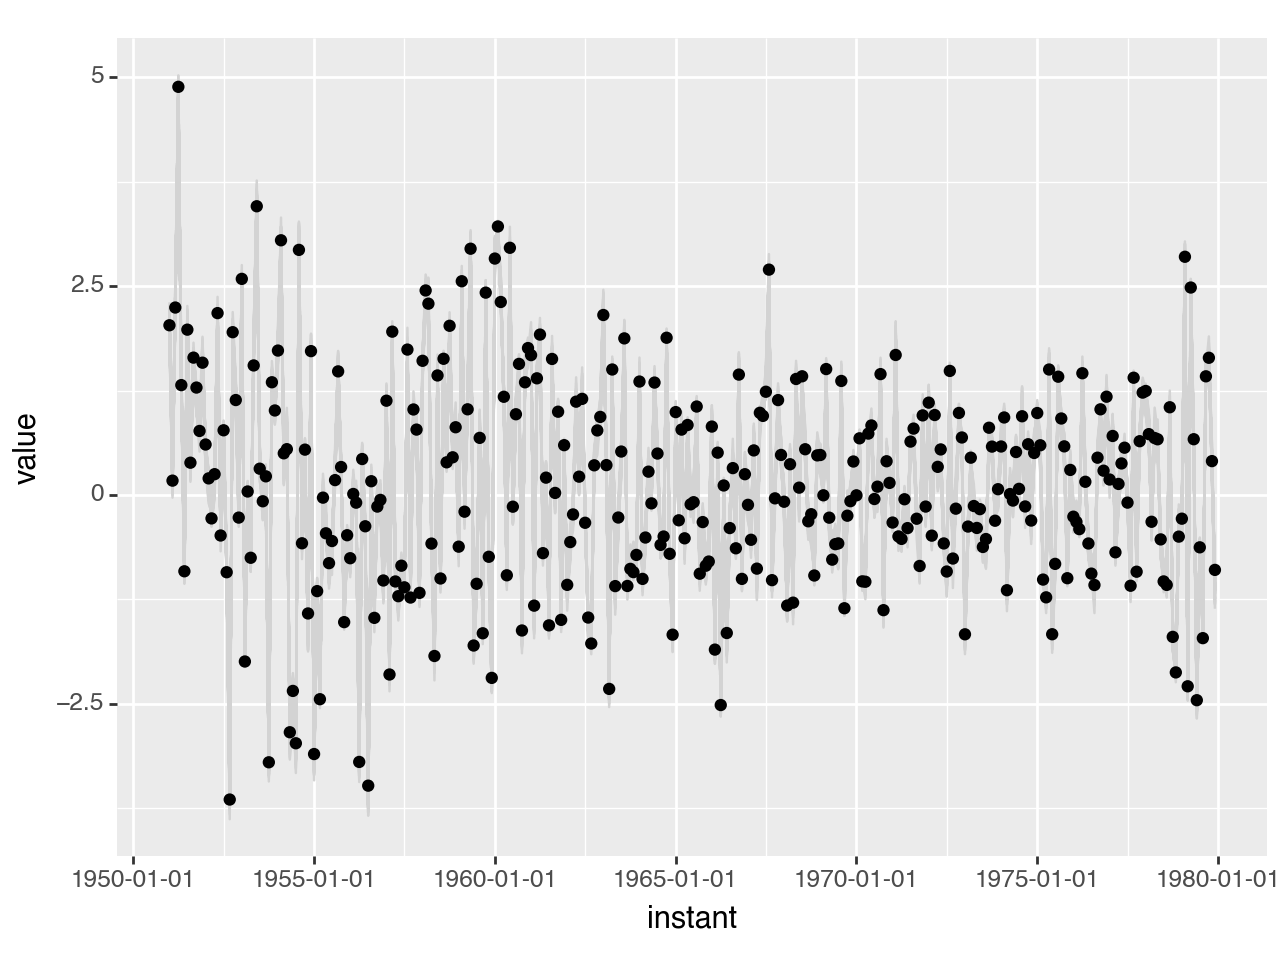

<Figure Size: (640 x 480)>

In [22]:
vb_params = dr.get_vb_parameter_sample(q=vb_param_q, num_samples=1)
pl.timeseries_obs_vs_fit(lines=False, points=True,
                         params=vb_params,
                         num_model_samples=60)

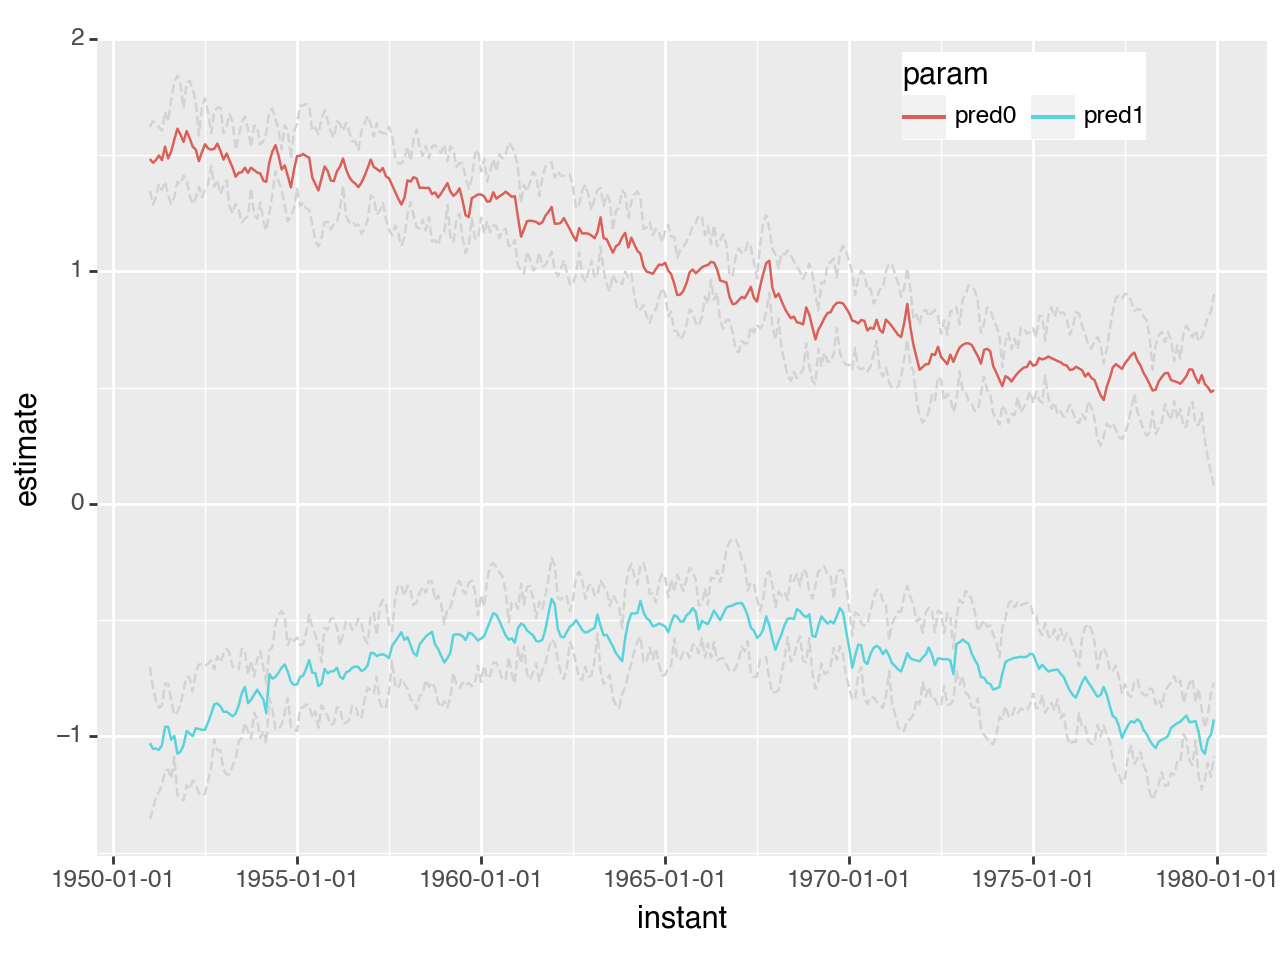

<Figure Size: (640 x 480)>

In [23]:
pl.timeseries_regression_coeffs(params=vb_params)

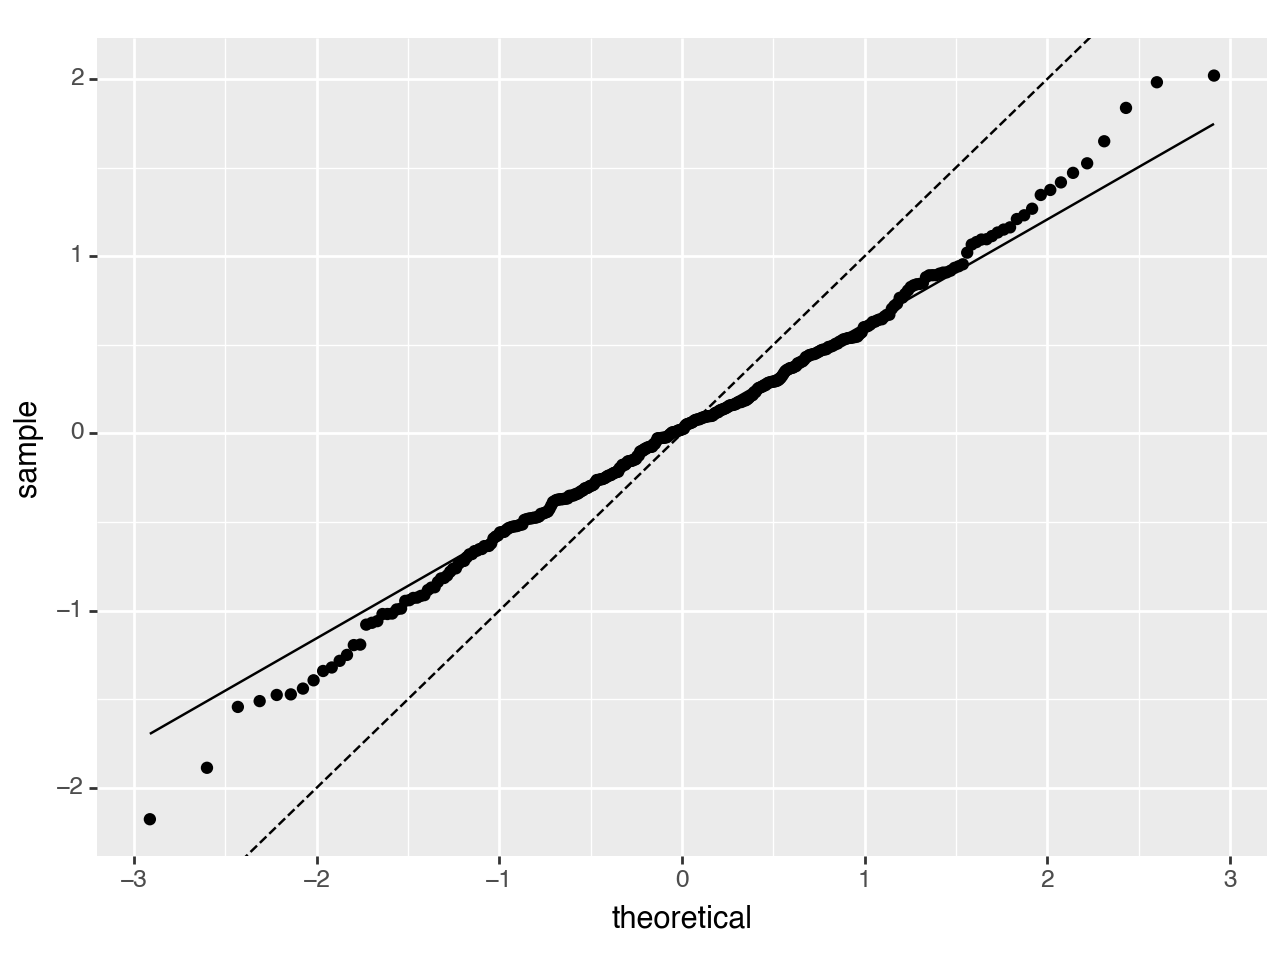

<Figure Size: (640 x 480)>

In [24]:
pl.forecast_residuals_qqplot(params=vb_params)

## Diagnostics

Here we compare the diagnostics for the 3 model runs. We'll drop the first year to allow for model burn-in.

In [25]:
time_endpoints = ['1951-01', '1980-01']
diagnostics = pd.concat(
    [pd.DataFrame(dr.get_diagnostics(params=pp, time_endpoints=time_endpoints, model_name=nm), index=[i])
     for i, pp, nm in zip(range(3), [params, map_params, vb_params], ['no_opt', 'map', 'vb'])],
    axis=0)
diagnostics

,name,rmse,mae,bias,frac_errors_gt_2sd,crps
0,no_opt,0.480484,0.313995,0.062345,0.000000,0.773744
1,map,0.172435,0.110423,0.007441,0.002874,0.088349
2,vb,0.174596,0.112324,0.007655,0.005747,0.087997
